# motion segmentation with spatial transform

## dataset
- FBMS-59-3D (only part of ground true)
- FBMS-59
- BMS (video format, not very good)
- DAVIS (not motion segmentation, but main motion object segmentation)
- CamouflagedAnimalDataset (not spatial transform)
- complexBackground-multilabel (not spatial transform)
- changedetection2012/2014 (not spatial transform)

In [1]:
import os
import glob
import torch.utils.data as td
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch

project_dir=os.path.expanduser('~/git/torchseg')
os.chdir(project_dir)

from dataset.fbms_dataset import fbms_dataset
from dataset.cdnet_dataset import cdnet_dataset
from dataset.dataset_generalize import image_normalizations
from utils.augmentor import Augmentations
from utils.torch_tools import get_ckpt_path,load_ckpt
from utils.disc_tools import show_images, show_tensor_list
from utils.config import load_config
import argparse
from models.motionseg.motion_utils import get_parser,get_default_config,get_dataset
from utils.notebook import get_model_and_dataset

train dataset size 353
val dataset size 367
no checkpoint file given, auto find /home/yzbx/tmp/logs/motion/motion_unet_stn/FBMS/task012_bs4_f20/2019-03-11___20-59-33/model-last-30.pkl
pose shape torch.Size([4, 1, 6])
theta tensor([[[ 0.8928, -0.0158, -0.0041],
         [ 0.0134,  0.8748,  0.0132]],

        [[ 0.9179, -0.0124, -0.0020],
         [ 0.0151,  0.8984,  0.0130]],

        [[ 0.9178, -0.0128, -0.0033],
         [ 0.0133,  0.9012,  0.0151]],

        [[ 0.9149, -0.0134,  0.0012],
         [ 0.0130,  0.8998,  0.0066]]],
       device='cuda:0', grad_fn=<ViewBackward>)
0 -0.23692518 0.4351296 1.0 -1.0


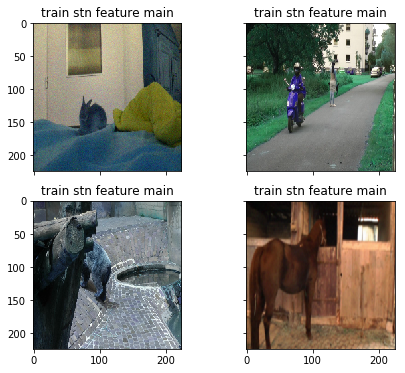

1 -0.24584524 0.4366285 1.0 -1.0


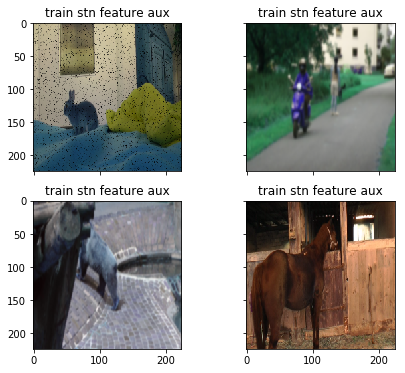

2 -0.2398126 0.43019006 1.0 -0.9924035


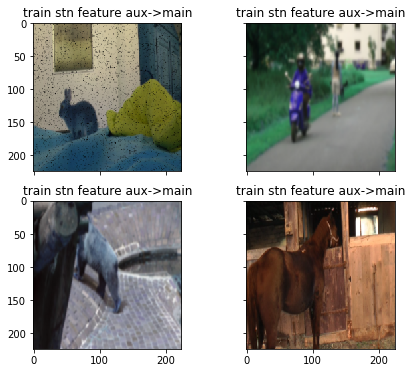

0 0.09135841836734694 0.28811813160709576 1 0


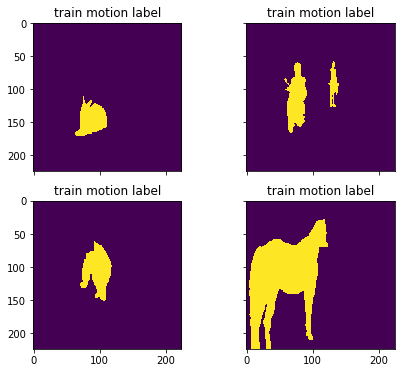

0 0.0694156568877551 0.2541596416951294 1 0


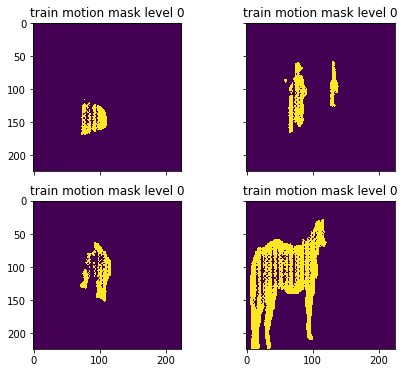

0 1.0 7.2592456e-09 1.0 0.99999994


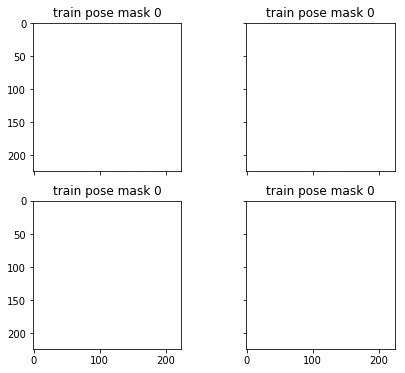

pose shape torch.Size([4, 1, 6])
theta tensor([[[ 0.7996, -0.0141, -0.0033],
         [ 0.0105,  0.7825,  0.0119]],

        [[ 0.9549, -0.0172, -0.0015],
         [ 0.0129,  0.9468,  0.0146]],

        [[ 0.9121, -0.0162, -0.0023],
         [ 0.0139,  0.8932,  0.0099]],

        [[ 0.8827, -0.0155, -0.0049],
         [ 0.0131,  0.8707,  0.0093]]],
       device='cuda:0', grad_fn=<ViewBackward>)
0 -0.07923508 0.44701606 1.0 -1.0


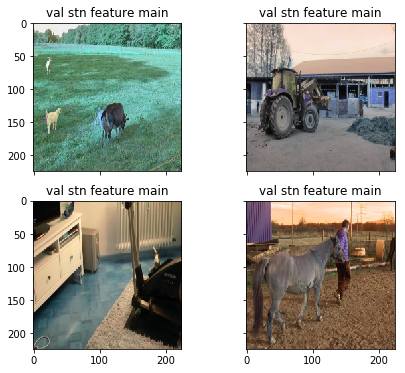

1 -0.09704526 0.43495196 1.0 -1.0


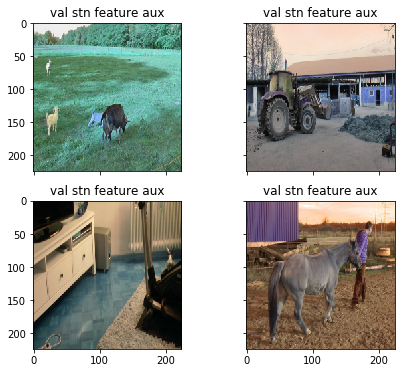

2 -0.10758859 0.41221187 1.0 -1.0


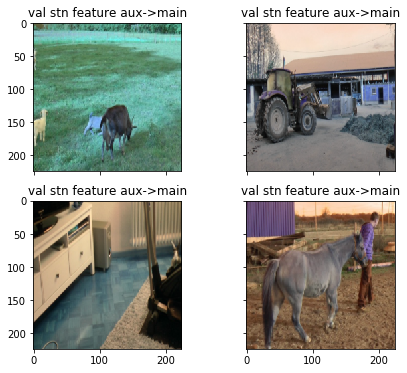

0 0.11228475765306123 0.31571647225296073 1 0


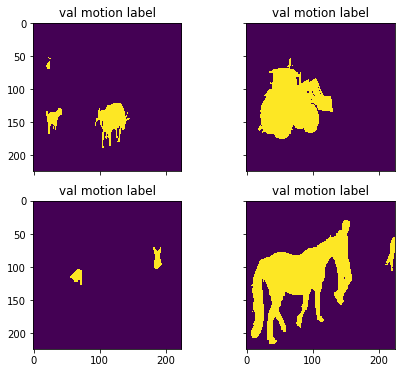

0 0.08786571269132654 0.2830995041051322 1 0


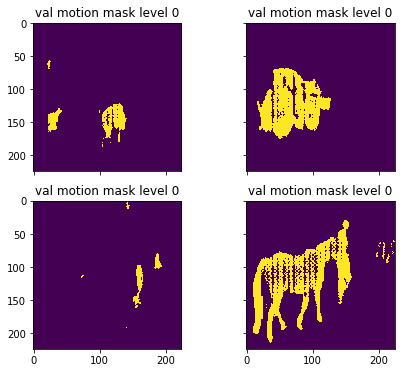

0 1.0 7.2787274e-09 1.0 0.99999994


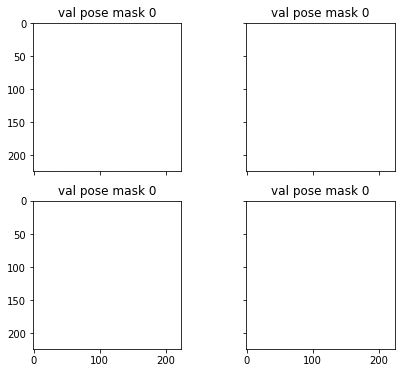

In [3]:
def stn_loss(features,motion,pose,pose_mask_reg=1.0):
    n=len(features)
    total_loss=0
    for i in range(n-1):
        theta=pose[:,i,:].view(-1,2,3)
        grid=F.affine_grid(theta,features[i+1].size())
        pose_mask=F.grid_sample(torch.ones_like(features[i+1]),grid)
        
        print('grid shape',grid.shape)
#         loss=F.l1_loss(features[0],features[i+1],reduction='none')
#         loss=F.l1_loss(features[0],features[i+1],reduction='none')
        loss=torch.abs(features[0]-features[i+1])
        print('l1_loss shape',loss.shape)
        loss=torch.clamp(loss,min=0,max=2.0)
        print('l1_loss clamp shape',loss.shape)
        print('features[0] shape',features[0].shape)
        print('features[1] shape',features[1].shape)
        print('pose mask shape',pose_mask.shape)
        
        print('l1_loss',torch.mean(loss).item())
        print('feature 0',torch.mean(features[0]).item(),torch.max(features[0]).item(),torch.min(features[0]).item())
        print('feature 1',torch.mean(features[1]).item(),torch.max(features[1]).item(),torch.min(features[1]).item())
        total_loss+=torch.mean(loss*(1-motion)*pose_mask)
        print('total_loss',total_loss.item())
        pose_reg_loss=pose_mask_reg*torch.mean(1-pose_mask)
        print('pose_reg_loss',pose_reg_loss.item())
        total_loss+=pose_reg_loss
    return total_loss

# config_list='--net_name motion_unet_stn --backbone_name vgg11'
# config_list+=' --upsample_layer 1 --freeze_layer 0 --deconv_layer 5 --use_none_layer False'
# config_list+=' --use_part_number 1000 --note task015_fg5 --dataset BMCnet'
# model,dataset_loaders,normer=get_model_and_dataset(config_list.split())

config_file='/home/yzbx/tmp/logs/motion/motion_unet_stn/FBMS/task012_bs4_f20/2019-03-11___20-59-33/config.txt'
model,dataset_loaders,normer=get_model_and_dataset(config_file)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()
for split in ['train','val']:
    for frames,gt in dataset_loaders[split]:
        images = [torch.autograd.Variable(img.to(device).float()) for img in frames]
        labels=torch.autograd.Variable(gt.to(device).long())
        outputs=model.forward(images)
#         stn_loss_value=stn_loss(outputs['stn_images'],labels.float(),outputs['pose'],config['pose_mask_reg'])
        
        pose=outputs['pose']
        print('pose shape',pose.shape)
        stn_features=[images[0],images[1]]
        pose_masks=[]
        n=len(images)
        for i in range(n-1):
            theta=pose[:,i,:].view(-1,2,3)
            print('theta',theta)
            grid=F.affine_grid(theta,images[i+1].size())
            aux_feature=F.grid_sample(images[i+1],grid)
            pose_mask=F.grid_sample(torch.ones_like(images[i+1]),grid)
            stn_features.append(aux_feature)
            pose_masks.append(pose_mask)
            
        image_list_title=['main','aux','aux->main']
        image_list_title=[split+' stn feature '+note for note in image_list_title]
        show_tensor_list(stn_features,image_list_title,normer)
        
        show_tensor_list([gt],[split+' motion label'])
        
        masks=[torch.argmax(x,dim=1,keepdim=True) for x in outputs['masks']]
        show_tensor_list(masks,[split+' motion mask level '+str(idx) for idx,t in enumerate(outputs['masks'])])
        
        show_tensor_list(pose_masks,[split+' pose mask ' +str(idx) for idx,t in enumerate(pose_masks)])

        break

0 117.03878680378402 57.35554621593819
1 114.75780253507654 55.81737216763688
2 113.28571926817602 52.56296354716962


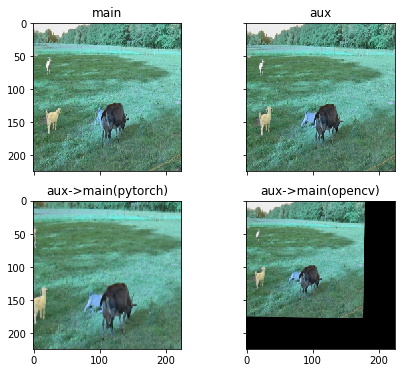

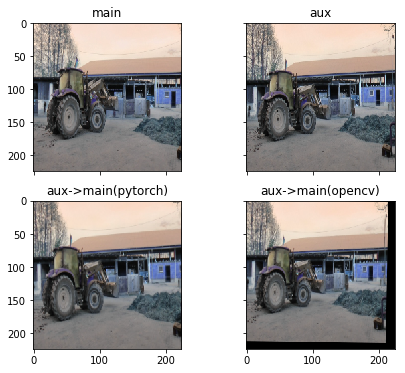

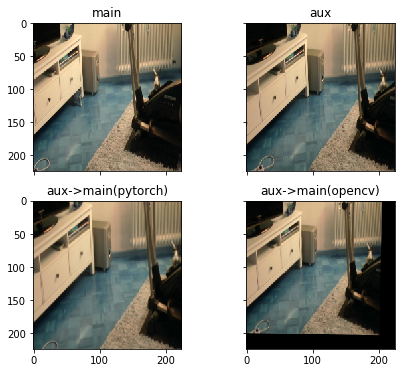

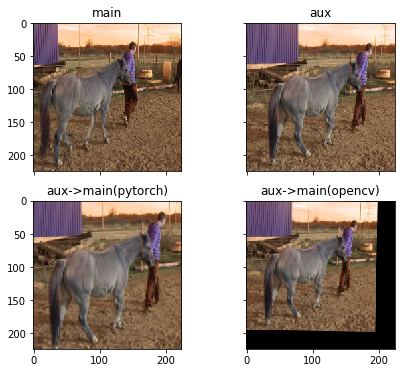

In [4]:
image_lists=[]
for idx,t in enumerate(stn_features):
    batch_images=t.data.cpu().numpy()
    batch_images=batch_images.transpose((0,2,3,1))
    batch_images=normer.backward(batch_images).astype(np.uint8)
    print(idx,np.mean(batch_images),np.std(batch_images))

    image_list=np.split(batch_images,4)
    image_list=[np.squeeze(img) for img in image_list]
    image_lists.append(image_list)

n=len(image_lists[0])
for idx in range(n):
    show_img_list=[image_lists[i][idx] for i in range(len(image_lists))]
    theta=pose[idx,0,:].view(2,3).data.cpu().numpy()
    aux_img=show_img_list[1]
    warp_img=cv2.warpAffine(aux_img,theta,aux_img.shape[0:2])
    show_img_list.append(warp_img)
    show_images(show_img_list,['main','aux','aux->main(pytorch)','aux->main(opencv)'])

In [5]:
config=load_config(config_file)
print(config)

import yaml
from easydict import EasyDict as edict
def load_config_full(config_file):
    f=open(config_file,'r')
    l=f.readline()
    f.close()

    d=yaml.load(l,Loader=yaml.FullLoader)
    config=edict(d)

    return config

config=load_config_full(config_file)
print(config)

{'app': 'train', 'backbone_freeze': False, 'backbone_name': 'vgg19_bn', 'backbone_pretrained': True, 'batch_size': 4, 'dataset': 'FBMS', 'deconv_layer': 5, 'epoch': 30, 'frame_gap': 20, 'freeze_layer': 0, 'freeze_ratio': 0.0, 'ignore_outOfRoi': True, 'init_lr': 0.0001, 'input_shape': [224, 224], 'layer_preference': 'last', 'log_dir': '/home/yzbx/tmp/logs/motion', 'merge_type': 'concat', 'modify_resnet_head': False, 'motion_loss_weight': 1.0, 'net_name': 'motion_unet_stn', 'note': 'task012_bs4_f20', 'pose_mask_reg': 1.0, 'psp_scale': 5, 'save_model': True, 'sparse_conv': False, 'sparse_ratio': 0.5, 'stn_loss_weight': 1.0, 'stn_object': 'images', 'test_path': 'dataset/FBMS/Testset', 'train_path': 'dataset/FBMS/Trainingset', 'upsample_layer': 1, 'upsample_type': 'bilinear', 'use_bias': True, 'use_bn': False, 'use_dropout': False, 'use_none_layer': False, 'use_part_number': 1000, 'val_path': 'dataset/FBMS/Testset'}
{'app': 'train', 'backbone_freeze': False, 'backbone_name': 'vgg19_bn', 'ba